In [1]:
from __future__ import print_function, absolute_import, division

import tensorflow as tf

tfe = tf.contrib.eager
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

# Load MNIST data

In [2]:
# 1. Load data
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

#print(train_images.shape, test_images.shape)

# 2. Reshape into n-by-28-28-1
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

#print(train_images.shape, test_images.shape)

# 3. Normalize the intensity into [0, 1]
train_images /= 255.
test_images /=  255.

# 4. Binarize
train_images[train_images >= 0.5] = 1.
train_images[train_images < 0.5] = 0.
test_images[test_images >= 0.5] = 1.
test_images[test_images < 0.5] = 0.


11493376/11490434 [==============================] - 0s 0us/step


In [3]:
TRAIN_BUFF = 60000
BATCH_SIZE = 100
TEST_BUFF = 10000

# Create Dataset

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUFF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUFF).batch(BATCH_SIZE)

# Build a convolution VAE  model

In [5]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # inference net
        self.inference_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2 * latent_dim)
        ])
        
        # generative net
        self.generative_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(7*7*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), 
                                            padding='SAME', activation='relu'),
            tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2),
                                            padding='SAME', activation='relu'),
            tf.keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=(1, 1), padding='SAME')
        ])
        
    def sample(self, eps=None):
        if eps == None:
            eps = tf.random_normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits        

# Define loss and optimizer

In [6]:
def log_normal_pdf(x, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((x - mean)**2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logits = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_logits)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    return -tf.reduce_sum(logpx_z + logpz - logqz_x)

def compute_gradient(model, x):
    with tf.GradientTape() as tp:
        loss = compute_loss(model, x)        
    return tp.gradient(loss, model.trainable_variables), loss

optimizer = tf.train.AdamOptimizer(1e-4)
def apply_gradients(optimizer, gradients, variables, global_step=None):
    return optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

# Train and generate images

In [7]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

random_vectors_for_generation = tf.random_normal(
    shape=(num_examples_to_generate, latent_dim))

model = CVAE(latent_dim)

In [8]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        
    # tigh_layout
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 100, Test set ELBO: -7837.3003515625, time elapse for current epoch: 50.903010845184326


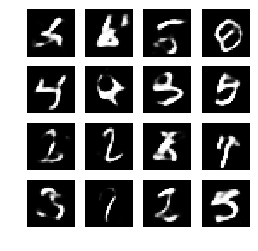

In [9]:
# train
generate_and_save_images(model, 0, random_vectors_for_generation)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        gradients, loss = compute_gradient(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()
    
    if epoch % 1 == 0:
        loss = tfe.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x)) # record each loss value
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
              'time elapse for current epoch: {}'. format(epoch, elbo, end_time - start_time))
        
        generate_and_save_images(model, epoch, random_vectors_for_generation)


In [33]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

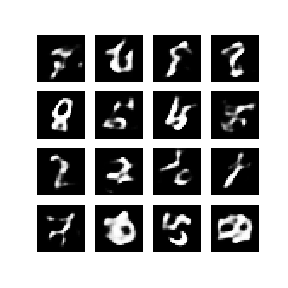

In [36]:
display_image(21)

# Generate a GIF

In [50]:
with imageio.get_writer('cvae.gif', mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp cvae.gif cvae.gif.png')

0

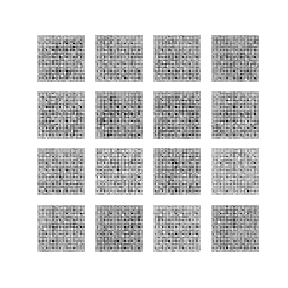

In [51]:
display.Image(filename="cvae.gif.png")